In [1]:
import os
import sys
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import seaborn as sns
sns.set_style("white")

%matplotlib inline

# import cv2
from sklearn.model_selection import train_test_split

from tqdm import tqdm_notebook #, tnrange
#from itertools import chain
from skimage.io import imread, imshow #, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model, save_model
from keras.layers import Input,Dropout,BatchNormalization,Activation,Add
from keras.layers.core import Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras import backend as K
from keras import optimizers

import tensorflow as tf

from keras.preprocessing.image import array_to_img, img_to_array, load_img#,save_img

import time
t_start = time.time()

/mnt/ml/anaconda35/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
img_size_ori = 101
img_size_target = 101

def upsample(img):# not used
    if img_size_ori == img_size_target:
        return img
    return resize(img, (img_size_target, img_size_target), mode='constant', preserve_range=True)
    
def downsample(img):# not used
    if img_size_ori == img_size_target:
        return img
    return resize(img, (img_size_ori, img_size_ori), mode='constant', preserve_range=True)

In [3]:
basic_path="data/tgs/"#"../input/tgs-salt-identification-challenge/"
# Loading of training/testing ids and depths
train_df = pd.read_csv(basic_path+"train.csv", index_col="id", usecols=[0])
depths_df = pd.read_csv(basic_path+"depths.csv", index_col="id")
train_df = train_df.join(depths_df)
test_df = depths_df[~depths_df.index.isin(train_df.index)]

len(train_df)

4000

In [4]:
train_df["images"] = [np.array(load_img(basic_path+"TRN_images/{}.png".format(idx), grayscale=True)) / 255 for idx in tqdm_notebook(train_df.index)]

A Jupyter Widget

/mnt/ml/anaconda35/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


In [5]:
train_df["masks"] = [np.array(load_img(basic_path+"TRN_masks/{}.png".format(idx), grayscale=True)) / 255 
                     for idx in tqdm_notebook(train_df.index)]

A Jupyter Widget

/mnt/ml/anaconda35/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


In [6]:
train_df["coverage"] = train_df.masks.map(np.sum) / pow(img_size_ori, 2)

def cov_to_class(val):    
    for i in range(0, 21):
        if val * 20 <= i :
            return i
        
train_df["coverage_class"] = train_df.coverage.map(cov_to_class)

In [7]:
# Create train/validation split stratified by salt coverage

ids_train, ids_valid, x_train, x_valid, y_train, y_valid, cov_train, cov_test, depth_train, depth_test = train_test_split(
    train_df.index.values,
    np.array(train_df.images.map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1), 
    np.array(train_df.masks.map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1), 
    train_df.coverage.values,
    train_df.z.values,
    test_size=0.12, stratify=train_df.coverage_class, random_state= 1224)

import gc
del x_train, x_valid, y_train, y_valid, cov_train, cov_test, depth_train, depth_test 
gc.collect()

7

In [8]:
print(ids_valid.shape)
ids_train[:5]

(480,)


array(['99b602dde4', '07bb074759', '9c4468a160', 'fc87224914',
       '40a7f422e2'], dtype=object)

In [9]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
from fastai.conv_learner import *
from fastai.dataset import *
from fastai.models.resnet import vgg_resnet50
from fastai.models.senet import *
from skimage.transform import resize
import json
from sklearn.model_selection import train_test_split, StratifiedKFold , KFold
from sklearn.metrics import jaccard_similarity_score
from pycocotools import mask as cocomask
from utils import my_eval,intersection_over_union_thresholds,RLenc
from lovasz_losses import lovasz_hinge
print(torch.__version__)
print(torch.cuda.is_available())
#True 注意GPU是set True

0.3.1
True


In [10]:
torch.backends.cudnn.benchmark=True 

In [11]:
PATH = Path('data/tgs/')
TRN_MASKS = 'trn_masks'
TRN_IMG = 'trn_images'
TRN_MSK = 'trn_masks'
TST_IMG = 'tst_images'
trn = pd.read_csv(PATH/'train.csv')
dpth = pd.read_csv(PATH/'depths.csv')

In [12]:
def show_img(im, figsize=None, ax=None, alpha=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im, alpha=alpha)
    ax.set_axis_off()
    return ax

In [13]:
class DepthDataset(Dataset):
    def __init__(self,ds,dpth_dict):
        self.dpth = dpth_dict
        self.ds = ds
        
    def __getitem__(self,i):
        val = self.ds[i]
        return val[0],self.dpth[self.ds.fnames[i].split('/')[1][:-4]],val[1]
    
class MatchedFilesDataset(FilesDataset):
    def __init__(self, fnames, y, transform, path):
        self.y=y
        assert(len(fnames)==len(y))
        super().__init__(fnames, transform, path)
        
    def get_x(self, i): 
        return open_image(os.path.join(self.path, self.fnames[i]))
    
    def get_y(self, i):
        return open_image(os.path.join(str(self.path), str(self.y[i])))

    def get_c(self): return 0
    
class TestFilesDataset(FilesDataset):
    def __init__(self, fnames, y, transform,flip, path):
        self.y=y
        self.flip = flip
        super().__init__(fnames, transform, path)
        
    def get_x(self, i): 
        im = open_image(os.path.join(self.path, self.fnames[i]))
        return np.fliplr(im) if self.flip else im
        
    def get_y(self, i):
        im = open_image(os.path.join(str(self.path), str(self.y[i])))
        return np.fliplr(im) if self.flip else im
    def get_c(self): return 0

In [14]:
x_names = np.array([f'{TRN_IMG}/{o.name}' for o in (PATH/TRN_MASKS).iterdir()])
y_names = np.array([f'{TRN_MASKS}/{o.name}' for o in (PATH/TRN_MASKS).iterdir()])
tst_x = np.array([f'{TST_IMG}/{o.name}' for o in (PATH/TST_IMG).iterdir()])
f_name = [o.split('/')[-1] for o in x_names]

c = dpth.set_index('id')



In [15]:
train_folds=[]
val_folds=[]

train_fold=[]
val_fold=[]
for img_name in ids_train:
    train_fold.append(img_name+".png")
    train_fold.append(img_name+"_Crop.png")
#     train_fold.append(img_name+"_aug2.png")
train_folds.append(train_fold)

for img_name in ids_valid:
    val_fold.append(img_name+".png")
val_folds.append(val_fold)

In [16]:
print(len(val_folds))
print(len(val_folds[0]))  # 8折交叉验证  只存放了图片名字 跑前5折即可

print(len(train_folds))
print(len(train_folds[0]))

1
480
1
7040


In [17]:
dpth_dict = c['z'].to_dict()
for item in ids_train:
    dpth_dict[item+"_aug1"]=dpth_dict[item]
    dpth_dict[item+"_aug2"]=dpth_dict[item]
    dpth_dict[item+"_Crop"]=dpth_dict[item]
    
print(len(dpth_dict.items())) # 22000+3520*2 

kf = 8
# kfold = KFold(n_splits=kf, shuffle=True, random_state=42) # 设置shuffle=True和random_state=整数，发现每次运行的结果都相同

# train_folds = []
# val_folds = []
# for idxs in kfold.split(f_name):
#     train_folds.append([f_name[idx] for idx in idxs[0]])
#     val_folds.append([f_name[idx] for idx in idxs[1]])

32560


In [18]:
# class SaveFeatures():
#     features=None
#     def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
#     def hook_fn(self, module, input, output): self.features = output
#     def remove(self): self.hook.remove()
    
# class scSEModule(nn.Module):
#     def __init__(self, ch, re=4):
#         super().__init__()
#         self.cSE = nn.Sequential(nn.AdaptiveAvgPool2d(1),
#                                  nn.Conv2d(ch,ch//re,1),
#                                  nn.ReLU(inplace=True),
#                                  nn.Conv2d(ch//re,ch,1),
#                                  nn.Sigmoid()
#                                )
#         self.sSE = nn.Sequential(nn.Conv2d(ch,ch,1),
#                                  nn.Sigmoid())

#     def forward(self, x):
#         return x * self.cSE(x) + x * self.sSE(x)
    
# # decoder block 设计太简单，可以增强一些
# class UnetBlock(nn.Module):
#     def __init__(self, up_in, x_in, n_out,dropout_ratio=0):
#         super().__init__()
#         up_out = x_out = n_out//2
#         self.x_conv  = nn.Conv2d(x_in,  x_out,  1) # x_in 经过一个1x1卷积 调节通道数对齐
#         self.tr_conv = nn.ConvTranspose2d(up_in, up_out, 2, stride=2)
#         self.bn = nn.BatchNorm2d(n_out)
        
#         self.scSE= scSEModule(n_out,re=2)
        
#         self.dropout_ratio=dropout_ratio
        
#     def forward(self, up_p, x_p):
#         up_p = self.tr_conv(up_p)
#         x_p = self.x_conv(x_p)
#         cat_p = torch.cat([up_p,x_p], dim=1)
#         cat_p= self.bn(F.relu(cat_p))
#         out=F.dropout2d(self.scSE(cat_p),self.dropout_ratio,training=self.training)
#         return out
    
# class Unet34(nn.Module):
#     def __init__(self, rn):
#         super().__init__()
#         self.rn = rn
#         self.sfs = [SaveFeatures(rn[i]) for i in [3,6,8,10]] #提取 2 4 5 6的输出features 
        
#         self.encoder_enhance=nn.Sequential( scSEModule(512,re=4),
#                                             nn.Dropout2d(p=0.1))
        
#         self.middle=nn.Conv2d(512,512,1,stride=1)
        
#         self.up1 = UnetBlock(512,256,128,dropout_ratio=0.2)
#         self.up2 = UnetBlock(128,128,128,dropout_ratio=0.2)
#         self.up3 = UnetBlock(128,64,128, dropout_ratio=0.2)
#         self.up4 = UnetBlock(128,64,128, dropout_ratio=0.2)
#         self.up5 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        
#         self.final=nn.Conv2d(64,1,1)
        
#     def forward(self,img,depth):
#         #print("model.trainging:",self.training)
#         # encoder 
#         x = F.relu(self.rn(img))
#         x = self.encoder_enhance(x)
#         Summary=False
#         if Summary:
#             print("encoder out:",x.shape)
        
#         x= self.middle(x)
        
#         x = self.up1(x, self.sfs[3].features) # 这样似乎就断开了直接的改变loss
#         if Summary:
#             print("decoder up1:",x.shape)
            
#         x = self.up2(x, self.sfs[2].features)
#         if Summary:
#             print("decoder up2:",x.shape)
            
#         x = self.up3(x, self.sfs[1].features)
#         if Summary:
#             print("decoder up3:",x.shape)
            
#         x = self.up4(x, self.sfs[0].features)
#         if Summary:
#             print("decoder up4:",x.shape)
            
#         x = self.up5(x)
#         if Summary:
#             print("decoder up5:",x.shape)
            
#         x = self.final(x)
#         if Summary:
#             print("decoder final:",x.shape)
#         return x[:,0]  # [bs,H,W]
    
#     def close(self):
#         for sf in self.sfs: sf.remove()


# class UnetModel():
#     def __init__(self,model,lr_cut,name='unet'):
#         self.model,self.name = model,name
#         self.lr_cut = lr_cut
#         #print(self.model)

#     def get_layer_groups(self, precompute):
        
#         #lgs = list(split_by_idxs(children(self.model.rn), [self.lr_cut]))
#         lgs = list(children(self.model.rn))
#         low=[lgs[0],lgs[1],lgs[2],lgs[4],lgs[5],lgs[7]]
#         print("low:",len(low))
#         middle=[lgs[9],lgs[11]]
#         print("middle:",len(middle))
#         high=[lgs[3],lgs[6],lgs[8],lgs[10],children(self.model)[1:]]
#         print("high:",len(high))
#         groups=[]
#         groups.append(low)
#         groups.append(middle)
#         groups.append(high)
#         return groups

In [19]:
class SaveFeatures():
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = output
    def remove(self): self.hook.remove()

class scSEModule(nn.Module):
    def __init__(self, ch, re=4):
        super().__init__()
        self.cSE = nn.Sequential(nn.AdaptiveAvgPool2d(1),
                                 nn.Conv2d(ch,ch//re,1),
                                 nn.ReLU(inplace=True),
                                 nn.Conv2d(ch//re,ch,1),
                                 nn.Sigmoid()
                               )
        self.sSE = nn.Sequential(nn.Conv2d(ch,ch,1),
                                 nn.Sigmoid())

    def forward(self, x):
        return x * self.cSE(x) + x * self.sSE(x)        

class UnetBlock(nn.Module):
    def __init__(self, up_in, x_in, n_out,dropout_ratio=0):
        super().__init__()
        up_out = x_out = n_out//2
        self.x_conv  = nn.Conv2d(x_in,  x_out,  1) # x_in 经过一个1x1卷积 调节通道数对齐
        self.tr_conv = nn.ConvTranspose2d(up_in, up_out, 2, stride=2)
        self.bn = nn.BatchNorm2d(n_out)
        
        self.scSE= scSEModule(n_out,re=4)
        
        self.dropout_ratio=dropout_ratio
        
    def forward(self, up_p, x_p):
        up_p = self.tr_conv(up_p)
        x_p = self.x_conv(x_p)
        cat_p = torch.cat([up_p,x_p], dim=1)
        cat_p= self.bn(F.relu(cat_p))
        out=F.dropout2d(self.scSE(cat_p),self.dropout_ratio,training=self.training)
        return out
    
class Unet34(nn.Module):
    def __init__(self, rn):
        super().__init__()
        self.rn = rn
        self.sfs = [SaveFeatures(rn[i]) for i in [3,6,8,10]]
        
        self.encoder_enhance=nn.Sequential( scSEModule(512,re=4),
                                            )
        
        self.middle=nn.Conv2d(512,512,1,stride=1)
        
        # 刚开始时，将dropout 为0，观察训练是否过拟合后再决定增大丢弃率
        self.up1 = UnetBlock(512,256,256,dropout_ratio=0.4)
        self.up2 = UnetBlock(256,128,256,dropout_ratio=0.4)
        self.up3 = UnetBlock(256,64,128, dropout_ratio=0.3)
        self.up4 = UnetBlock(128,64,128, dropout_ratio=0.3)
        self.up5 = nn.ConvTranspose2d(128, 96, 2, stride=2)
        
        self.final=nn.Conv2d(96,1,1)
        
        # Hypercolumn 未实现
        
    def forward(self,img,depth):
        x = F.relu(self.rn(img))
        
        x = self.encoder_enhance(x)
        x= self.middle(x)
        
        x = self.up1(x, self.sfs[3].features)
        x = self.up2(x, self.sfs[2].features)
        x = self.up3(x, self.sfs[1].features)
        x = self.up4(x, self.sfs[0].features)
        x = self.up5(x)
        x=F.dropout2d(x,0.1,training=self.training)
        x = self.final(x)
        
        return x[:,0] # 注意: lovasz_hinge 要求的 preds shape为 [Bs,H,W] 而非[Bs,1,H,W], gt_mask的shape也必须为[Bs,H,W] 
    
    def close(self):
        for sf in self.sfs: sf.remove()


# class UnetModel():
#     def __init__(self,model,lr_cut,name='unet'):
#         self.model,self.name = model,name
#         self.lr_cut = lr_cut

#     def get_layer_groups(self, precompute):
#         lgs = list(split_by_idxs(children(self.model.rn), [self.lr_cut]))
#         return lgs + [children(self.model)[1:]]
    
class UnetModel():
    def __init__(self,model,lr_cut,name='unet'):
        self.model,self.name = model,name
        self.lr_cut = lr_cut

    def get_layer_groups(self, precompute):
        
        #lgs = list(split_by_idxs(children(self.model.rn), [self.lr_cut]))
        lgs = list(children(self.model.rn))
        low=[lgs[0],lgs[1],lgs[2],lgs[4],lgs[5],lgs[7]]
        middle=[lgs[9],lgs[11]]
        
        
        high=[lgs[3],lgs[6],lgs[8],lgs[10]]
        decoder=children(self.model)[1:]
        
        groups=list()
        groups.append(low)
        groups.append(middle)
        groups.append(high)
        groups.append(decoder)
        
        
        return groups

In [20]:

def get_tgs_model():
    f = resnet34
    cut,lr_cut = model_meta[f] # 8,6
    m_base = get_base(f,cut)
    m = to_gpu(Unet34(m_base))
    models = UnetModel(m,lr_cut)
    learn = ConvLearner(md, models)
    
    return learn

def get_base(f,cut):
    layers = cut_model(f(True), cut)
    
    num_channel={"2":64,"4":64,"5":128,"6":256}
    decoder=[]
    for i in range(len(layers)):
        decoder.append(layers[i])
        if i in set([2,4,5,6]):
            decoder.append(nn.Sequential(  scSEModule(num_channel[str(i)],re=4)
                                        ))
       
    return nn.Sequential(*decoder)

In [21]:
# tmp=get_tgs_model()

# x=torch.randn(2,3,256,256)
# tmp.train()
# #tmp.eval()
# tmp(Variable(x),1)

# Training Stage --- do not run it if just test

In [21]:
model = 'simple_resnet34'
bst_acc=[]
use_clr_min=20
use_clr_div=10
aug_tfms =[RandomFlip(tfm_y=TfmType.CLASS)]

szs = [(256,64)]
for sz,bs in szs:
    print([sz,bs])
    for i in range(kf-4) :
        print(f'fold_id{i}')
        
        trn_x = np.array([f'trn_images/{o}' for o in train_folds[0]])
        trn_y = np.array([f'trn_masks/{o}' for o in train_folds[0]])
        val_x = [f'trn_images/{o}' for o in val_folds[0]]
        val_y = [f'trn_masks/{o}' for o in val_folds[0]]
        
        tfms = tfms_from_model(resnet34, sz=sz, pad=0,crop_type=CropType.NO, tfm_y=TfmType.CLASS, aug_tfms=aug_tfms)
        datasets = ImageData.get_ds(MatchedFilesDataset, (trn_x,trn_y), (val_x,val_y), tfms,test=tst_x,path=PATH)
        md = ImageData(PATH, datasets, bs, num_workers=8, classes=None)
        denorm = md.trn_ds.denorm
        md.trn_dl.dataset = DepthDataset(md.trn_ds,dpth_dict)
        md.val_dl.dataset = DepthDataset(md.val_ds,dpth_dict)
        md.test_dl.dataset = DepthDataset(md.test_ds,dpth_dict)
        learn = get_tgs_model() 
        learn.opt_fn = optim.Adam
        learn.metrics=[my_eval]
        pa = f'{kf}_fold_{model}_{i}'
        print(pa)

        lr=1e-2
        wd=5e-7  #1e-7 
        lrs = np.array([lr/50,lr/5,lr/10,lr])

        learn.unfreeze()        
        learn.crit = lovasz_hinge
        learn.load(pa)
        learn.fit(lrs/4,3, wds=wd, cycle_len=10,use_clr=(20,8),best_save_name=pa)

        learn.load(pa)        
        #Calcuating mean iou score
        v_targ = md.val_ds.ds[:][1]
        v_preds = np.zeros((len(v_targ),sz,sz))     
        v_pred = learn.predict()
        v_pred = to_np(torch.sigmoid(torch.from_numpy(v_pred)))
        p = ((v_pred)>0.5).astype(np.uint8)
        bst_acc.append(intersection_over_union_thresholds(v_targ,p))
        print(bst_acc[-1])

[256, 64]
fold_id0
8_fold_simple_resnet34_0


A Jupyter Widget

epoch      trn_loss   val_loss   my_eval                     
    0      0.441934   0.958804   0.816042  
    1      0.492798   0.948809   0.816667                    
    2      0.466649   0.936678   0.81                        
    3      0.450486   0.910958   0.79625                     
    4      0.421505   0.992493   0.804375                    
    5      0.40334    1.013278   0.810208                    
    6      0.39602    0.957814   0.814792                    
    7      0.395973   0.927739   0.825833                    
    8      0.373807   1.003346   0.823958                    
    9      0.360309   1.011903   0.820625                    
    10     0.379503   1.179822   0.803333                    
    11     0.431641   0.918733   0.811875                    
    12     0.456422   0.923998   0.8125                      
    13     0.417033   0.95602    0.785417                    
    14     0.399523   0.978365   0.792083                    
    15     0.399098   0.98

FileNotFoundError: [Errno 2] No such file or directory: 'data/tgs/models/8_fold_simple_resnet34_1.h5'

In [ ]:
bst_acc,np.mean(bst_acc)#With 256



```python 
第5次训练  lr=1e-2
        wd=5e-7  #1e-7 
        lrs = np.array([lr/1,lr/1,lr/1,lr])/2

epoch      trn_loss   val_loss   my_eval                    
    0      1.361808   1.768405   0.563333  
    1      1.271945   1.393701   0.6325                     
    2      1.22546    1.103285   0.717292                   
    3      1.100603   1.060564   0.721667                   
    4      1.040772   0.971689   0.74375                    
    5      1.000974   0.968966   0.744375                    
    6      0.928853   0.874145   0.786458                    
    7      0.898107   0.826325   0.78625                     
    8      0.849922   0.829726   0.780417                    
    9      0.793904   0.829265   0.793958                    
    10     0.949336   0.999378   0.745417                    
    11     1.087053   1.014289   0.727917                   
    12     1.007459   0.994917   0.746042                   
    13     0.989709   0.953513   0.773958                    
    14     0.953903   0.922847   0.762917                    
    15     0.913904   0.90461    0.753333                    
    16     0.831526   0.853023   0.777708                    
    17     0.804177   0.834908   0.794167                    
    18     0.77297    0.860319   0.780417                    
    19     0.737809   0.821741   0.795833                    
    20     0.83418    0.942018   0.742708                    
    21     0.943794   0.955236   0.768542                    
    22     0.916414   1.000631   0.759583                    
    23     0.888202   0.916103   0.779167                    
    24     0.819576   0.84601    0.792292                    
    25     0.793027   0.84377    0.770208                    
    26     0.771033   0.799559   0.80125                     
    27     0.735788   0.859489   0.773125                    
    28     0.698546   0.835086   0.786458                    
    29     0.699825   0.804718   0.805625   

```

```python
第三次训练  lr=1e-2 wd=1e-7 lrs = np.array([lr/100,lr/10,lr/2,lr])/5

epoch      trn_loss   val_loss   my_eval                     
    0      0.724177   0.847318   0.81375   
    1      0.57606    0.894748   0.813333                    
    2      0.513421   0.854107   0.822917                    
    3      0.464027   0.879192   0.820625                    
    4      0.433076   0.990956   0.811042                    
    5      0.43867    0.951688   0.804583                    
    6      0.428984   0.920455   0.821042                    
    7      0.401499   0.978546   0.819375                    
    8      0.399173   0.97308    0.8175                      
    9      0.397164   0.984055   0.82625                     
    10     0.392509   0.956659   0.815625                    
    11     0.412007   0.951582   0.81625                     
    12     0.412894   0.900382   0.820833                    
    13     0.399977   0.941249   0.816667                    
    14     0.381477   0.992753   0.816458                    
    15     0.372505   0.956275   0.814583                    
    16     0.36326    1.025224   0.798958                    
    17     0.357849   1.09216    0.806875                    
    18     0.358487   0.987846   0.811458                    
    19     0.353797   1.012645   0.810625                    
    20     0.354088   1.048793   0.824792                    
    21     0.393511   1.001458   0.807083                    
    22     0.380662   1.022685   0.819792                    
    23     0.364358   0.975018   0.804583                    
    24     0.364864   1.047795   0.8125                      
    25     0.351582   0.960161   0.805                       
    26     0.34741    1.065952   0.804375                    
    27     0.336437   1.05489    0.815417                    
    28     0.336922   1.064214   0.807708                    
    29     0.336781   1.069093   0.803542   
```

# 备份

In [ ]:
class SaveFeatures():
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = output
    def remove(self): self.hook.remove()

class scSEModule(nn.Module):
    def __init__(self, ch, re=4):
        super().__init__()
        self.cSE = nn.Sequential(nn.AdaptiveAvgPool2d(1),
                                 nn.Conv2d(ch,ch//re,1),
                                 nn.ReLU(inplace=True),
                                 nn.Conv2d(ch//re,ch,1),
                                 nn.Sigmoid()
                               )
        self.sSE = nn.Sequential(nn.Conv2d(ch,ch,1),
                                 nn.Sigmoid())

    def forward(self, x):
        return x * self.cSE(x) + x * self.sSE(x)        

class UnetBlock(nn.Module):
    def __init__(self, up_in, x_in, n_out,dropout_ratio=0):
        super().__init__()
        up_out = x_out = n_out//2
        self.x_conv  = nn.Conv2d(x_in,  x_out,  1) # x_in 经过一个1x1卷积 调节通道数对齐
        self.tr_conv = nn.ConvTranspose2d(up_in, up_out, 2, stride=2)
        self.bn = nn.BatchNorm2d(n_out)
        
        self.scSE= scSEModule(n_out,re=4)
        
        self.dropout_ratio=dropout_ratio
        
    def forward(self, up_p, x_p):
        up_p = self.tr_conv(up_p)
        x_p = self.x_conv(x_p)
        cat_p = torch.cat([up_p,x_p], dim=1)
        cat_p= self.bn(F.relu(cat_p))
        out=F.dropout2d(self.scSE(cat_p),self.dropout_ratio,training=self.training)
        return out
    
class Unet34(nn.Module):
    def __init__(self, rn):
        super().__init__()
        self.rn = rn
        self.sfs = [SaveFeatures(rn[i]) for i in [2,4,5,6]]
        
        self.encoder_enhance=nn.Sequential( scSEModule(512,re=4),
                                            nn.Dropout2d(p=0.1))
        
        self.middle=nn.Conv2d(512,512,1,stride=1)
        
        self.up1 = UnetBlock(512,256,128,dropout_ratio=0.2)
        self.up2 = UnetBlock(128,128,128,dropout_ratio=0.2)
        self.up3 = UnetBlock(128,64,128, dropout_ratio=0.2)
        self.up4 = UnetBlock(128,64,128, dropout_ratio=0.2)
        self.up5 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        
        self.final=nn.Conv2d(64,1,1)
        
    def forward(self,img,depth):
        x = F.relu(self.rn(img))
        
        x = self.encoder_enhance(x)
        x= self.middle(x)
        
        x = self.up1(x, self.sfs[3].features)
        x = self.up2(x, self.sfs[2].features)
        x = self.up3(x, self.sfs[1].features)
        x = self.up4(x, self.sfs[0].features)
        x = self.up5(x)
        
        x = self.final(x)
        
        return x[:,0]
    
    def close(self):
        for sf in self.sfs: sf.remove()


class UnetModel():
    def __init__(self,model,lr_cut,name='unet'):
        self.model,self.name = model,name
        self.lr_cut = lr_cut

    def get_layer_groups(self, precompute):
        lgs = list(split_by_idxs(children(self.model.rn), [self.lr_cut]))
        return lgs + [children(self.model)[1:]]

## 注释

In [24]:
# def get_tgs_model():
#     f = resnet34
    
#     cut,lr_cut = model_meta[f] # 返回 8,6 # 这个6表示 0-5为底层特征层 6-7为中层特征层 分别执行不同的学习率
#     #print(cut,lr_cut)
    
#     encoder = get_base(f,cut) # m_base 为 resNet34的前8个子mudule层，并封装成一个大的mudule 
#     m = to_gpu(Unet34(encoder))
   
#     models = UnetModel(m,lr_cut)
#     return models
# #     learn = ConvLearner(md, models)
# #     return learn,models

# def get_base(f,cut):
#     layers = cut_model(f(True), cut)
#     return nn.Sequential(*layers) # 取resNet34的前8个子mudule层，并封装成一个大的mudule # 改动: 在这些层之间插入一些新的层



In [25]:
# #??ConvLearner
# a=get_tgs_model()
# import torch 

# x=torch.randn(4,3,256,256)
# out=a.model(Variable(x))


```
encoder out: torch.Size([4, 512, 8, 8])
decoder up1: torch.Size([4, 128, 16, 16])
decoder up2: torch.Size([4, 128, 32, 32])
decoder up3: torch.Size([4, 128, 64, 64])
decoder up4: torch.Size([4, 128, 128, 128])
decoder up5: torch.Size([4, 1, 256, 256])
```

### 改动1

In [114]:
print(type(md.trn_y),md.trn_y.shape,md.trn_y)

print(md.val_y[:20])

print(md.trn_ds.y)

print(md.trn_ds.get_y(4).shape)


<class 'numpy.ndarray'> (3500,) ['trn_masks/3cc59342bd.png' 'trn_masks/4e5d643b2f.png' 'trn_masks/55e9012561.png' ...
 'trn_masks/8811181716.png' 'trn_masks/7d52a376a7.png' 'trn_masks/fe37eddf8e.png']
['trn_masks/d2ea97ca4e.png', 'trn_masks/4ad8a63538.png', 'trn_masks/9a6c280d8d.png', 'trn_masks/0461a2fb30.png', 'trn_masks/e446b0b4b6.png', 'trn_masks/b2958f2747.png', 'trn_masks/dc0119712d.png', 'trn_masks/e41a05735d.png', 'trn_masks/6f438c26f8.png', 'trn_masks/5c33b65396.png', 'trn_masks/f503aaf699.png', 'trn_masks/6a1fe1a81e.png', 'trn_masks/c593c662f1.png', 'trn_masks/00cda0328c.png', 'trn_masks/1a8a17f220.png', 'trn_masks/3df62de11d.png', 'trn_masks/ec406285e8.png', 'trn_masks/ffb2ad3f94.png', 'trn_masks/b0e479668d.png', 'trn_masks/b7b83447c4.png']
['trn_masks/3cc59342bd.png' 'trn_masks/4e5d643b2f.png' 'trn_masks/55e9012561.png' ...
 'trn_masks/8811181716.png' 'trn_masks/7d52a376a7.png' 'trn_masks/fe37eddf8e.png']
(101, 101, 3)
False


In [11]:
# bst_acc,np.mean(bst_acc)#With 256

In [12]:
# bst_acc,np.mean(bst_acc) #With 128

([0.814125, 0.8171250000000001, 0.8025, 0.8025, 0.82625], 0.8125)

### 第二次实验 ([0.814125, 0.8171250000000001, 0.8025, 0.8025, 0.82625], 0.8125)

# Submission - TTA

A Jupyter Widget

8_fold_simple_resnet34_0



A Jupyter Widget

8_fold_simple_resnet34_0



A Jupyter Widget

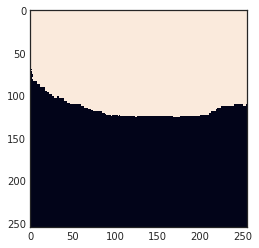

In [22]:
model = 'simple_resnet34'
bst_acc=[]
# use_clr_min=20
# use_clr_div=10
aug_tfms = [RandomFlip(tfm_y=TfmType.CLASS)]

sz=256
bs=32 # bs不能太大 否则内存溢出



trn_x = np.array([f'trn_images/{o}' for o in train_folds[0]])
trn_y = np.array([f'trn_masks/{o}' for o in train_folds[0]])
val_x = [f'trn_images/{o}' for o in val_folds[0]]
val_y = [f'trn_masks/{o}' for o in val_folds[0]]

tfms = tfms_from_model(resnet34, sz=sz, pad=0,crop_type=CropType.NO, tfm_y=TfmType.CLASS, aug_tfms=aug_tfms)
datasets = ImageData.get_ds(MatchedFilesDataset, (trn_x,trn_y), (val_x,val_y), tfms,test=tst_x,path=PATH)
md = ImageData(PATH, datasets, bs, num_workers=8, classes=None)
denorm = md.trn_ds.denorm
#md.trn_dl.dataset = DepthDataset(md.trn_ds,dpth_dict)
#md.val_dl.dataset = DepthDataset(md.val_ds,dpth_dict)
md.test_dl.dataset = DepthDataset(md.test_ds,dpth_dict)
 

import gc

model_num=0 # 0-4 依次导出所有模型的结果
preds = np.zeros(shape = (18000,sz,sz))
for o in [True,False]:
    md.test_dl.dataset = TestFilesDataset(tst_x,tst_x,tfms[1],flip=o,path=PATH)
    md.test_dl.dataset = DepthDataset(md.test_dl.dataset,dpth_dict)
    
    for i in tqdm_notebook(range(model_num,model_num+1)):
        pa = f'{kf}_fold_{model}_{i}'
        print("Load model from {}".format(pa))
        learn = get_tgs_model()
        learn.load(pa)
        pred = learn.predict(is_test=True)
        pred = to_np(torch.sigmoid(torch.from_numpy(pred)))    
        for im_idx,im in enumerate(pred):
            preds[im_idx] += np.fliplr(im) if o else im
        del pred
        del learn
        gc.collect()

plt.imshow(((preds[18]/2)>0.5).astype(np.uint8)) # 随意显示一张测试图片的结果

p = [cv2.resize(o/2,dsize=(101,101)) for o in preds]
p = [(o>0.5).astype(np.uint8) for o in p]

pred_dict = {id_[11:-4]:RLenc(p[i]) for i,id_ in tqdm_notebook(enumerate(tst_x))}
sub = pd.DataFrame.from_dict(pred_dict,orient='index')
sub.index.names = ['id']
sub.columns = ['rle_mask']
sub.to_csv('simple_k_fold_flipped_{}.csv'.format(model_num))

In [15]:
# tst_x[18]

'tst_images/69874e7963.png'

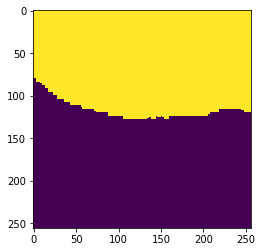

In [14]:
# plt.imshow(((preds[18]/10)>0.5).astype(np.uint8))

In [16]:
# p = [cv2.resize(o/10,dsize=(101,101)) for o in preds]
# p = [(o>0.5).astype(np.uint8) for o in p]

In [17]:
# pred_dict = {id_[11:-4]:RLenc(p[i]) for i,id_ in tqdm_notebook(enumerate(tst_x))}
# sub = pd.DataFrame.from_dict(pred_dict,orient='index')
# sub.index.names = ['id']
# sub.columns = ['rle_mask']
# sub.to_csv('simple_k_fold_flipped.csv')

A Jupyter Widget